In [1]:
import pickle
import sys
import os
import numpy as np
import pandas as pd
import glob

In [2]:
from tqdm.auto import tqdm
import sklearn.linear_model
from scipy.stats import pearsonr
from joblib import Parallel, delayed

/opt/homebrew/Caskroom/miniforge/base/envs/lcc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import random

random.seed(3)  # For reproducibility

## Load the data

In [4]:
with open('data/EXP2.pkl', 'rb') as f: 
	exp2_data = pickle.load(f)
with open('data/EXP3.pkl', 'rb') as f: 
    exp3_data = pickle.load(f)

In [5]:
voxel_neighbors = exp2_data['meta'][0][0][7]

In [6]:
#Let's load the functions from learn_decoder.py
from learn_decoder import read_matrix

# data for experiment 1
exp1_fmri = read_matrix("data/neuralData_for_EXP1.csv", sep=",", header=True, index_col=True)
exp1_vecs = read_matrix("data/vectors_180concepts.GV42B300.txt", sep=" ")
exp1_conc = np.genfromtxt('data/stimuli_180concepts.txt', dtype=np.dtype('U'))  #The names of the 180 concepts
# data for experiment 2
exp2_fmri = exp2_data['Fmridata']
exp2_vecs = read_matrix("data/vectors_384sentences.GV42B300.average.txt", sep=" ")
exp2_sent = np.genfromtxt('data/stimuli_384sentences.txt', delimiter='\t', dtype=np.dtype('U'))
# data for experiment 3
exp3_fmri = exp3_data['Fmridata']
exp3_vecs = read_matrix("data/vectors_243sentences.GV42B300.average.txt", sep=" ")
exp3_sent = np.genfromtxt('data/stimuli_243sentences.txt', delimiter='\t', dtype=np.dtype('U'))


## For Sentence Reconstruction

In [11]:
# finding the average number of words in exp2_sent and exp3_sent
avg_words_exp2 = sum(len(utt.split()) for utt in exp2_sent) / len(exp2_sent)
avg_words_exp2_std = (sum((len(utt.split()) - avg_words_exp2) ** 2 for utt in exp2_sent) / len(exp2_sent)) ** 0.5
avg_words_exp2_max = max(len(utt.split()) for utt in exp2_sent)
avg_words_exp2_min = min(len(utt.split()) for utt in exp2_sent)

avg_words_exp3 = sum(len(utt.split()) for utt in exp3_sent) / len(exp3_sent)
avg_words_exp3_std = (sum((len(utt.split()) - avg_words_exp3) ** 2 for utt in exp3_sent) / len(exp3_sent)) ** 0.5
avg_words_exp3_max = max(len(utt.split()) for utt in exp3_sent)
avg_words_exp3_min = min(len(utt.split()) for utt in exp3_sent)

print(f"Average number of words in exp2_sent: {avg_words_exp2:.2f} with std: {avg_words_exp2_std:.2f}. m,M: [{avg_words_exp2_min:.2f}, {avg_words_exp2_max:.2f}]")
print(f"Average number of words in exp3_sent: {avg_words_exp3:.2f} with std: {avg_words_exp3_std:.2f}. m,M: [{avg_words_exp3_min:.2f}, {avg_words_exp3_max:.2f}]")
print(f'Overall average number of words: {(avg_words_exp2 + avg_words_exp3) / 2:.2f} with std: {((avg_words_exp2_std ** 2 + avg_words_exp3_std ** 2) / 2) ** 0.5:.2f}. m,M: [{min(avg_words_exp2_min, avg_words_exp3_min):.2f}, {max(avg_words_exp2_max, avg_words_exp3_max):.2f}]')

Average number of words in exp2_sent: 11.82 with std: 2.09. m,M: [7.00, 19.00]
Average number of words in exp3_sent: 13.14 with std: 2.92. m,M: [5.00, 20.00]
Overall average number of words: 12.48 with std: 2.54. m,M: [5.00, 20.00]


In [7]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM

In [65]:
# loading the glove vectors from the data/glove.42B.300d.txt
glove_embs = {}
# if the embedding are already saved, we can load them
if os.path.exists('data/glove_embs.pkl'):
    with open('data/glove_embs.pkl', 'rb') as f:
        glove_embs = pickle.load(f)
else:
    # otherwise, we load them from the file
    with open('data/glove.42B.300d.txt', 'r', encoding='utf-8') as f:
        for line in f:
            split_line = line.split()
            word = split_line[0]
            vector = np.array([float(x) for x in split_line[1:]])
            glove_embs[word] = vector

In [15]:
# saving the glove embeddings
with open('data/glove_embs.pkl', 'wb') as f:
    pickle.dump(glove_embs, f)

In [9]:
def get_glove_sequence_embedding(text_sequence, tokenizer, model):
    """
    Calculates the semantic embedding for a sequence of text by averaging the GloVe word vectors.
    """
    words = text_sequence.split()
    word_vectors = [glove_embs[word] for word in words if word in glove_embs]
    if not word_vectors:
        # If no valid word vectors are found, return a zero vector.
        return np.zeros(300)
    # Average the word vectors to get the sequence embedding.
    sequence_embedding = np.mean(word_vectors, axis=0)
    return sequence_embedding

In [8]:
def get_llm_sequence_embedding(text_sequence, tokenizer, model):
    """
    Calculates the semantic embedding for a sequence of text averaging the hidden states of a language model.
    """
    inputs = tokenizer(text_sequence, return_tensors='pt', padding=True)
    with torch.no_grad():
        # Get the hidden states from the model output.
        outputs = model(**inputs, output_hidden_states=True)
        # We take the hidden states from the last layer.
        hidden_states = outputs.hidden_states[-1]
        # Average the token embeddings to get a single vector for the sequence.
        sequence_embedding = torch.mean(hidden_states, dim=1).squeeze().numpy()
    return sequence_embedding

In [9]:
def setup_model_and_tokenizer(model_name='mistralai/Mistral-7B-v0.3'):
    """
    Loads a pre-trained language model and tokenizer using AutoClass.

    AutoTokenizer and AutoModelForCausalLM are "smart" loaders that automatically
    infer the correct architecture from the model name and download the
    appropriate classes, weights, and configuration. This makes the code
    flexible enough to work with Mistral, Llama, GPT-2, Pythia, etc.
    """
    print(f"Loading {model_name} model and tokenizer...")
    # You can now use any compatible model from the Hugging Face Hub.
    
    # The AutoTokenizer will load the correct tokenizer for the Mistral model.
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # It's good practice to set a padding token if the model doesn't have one.
    # The end-of-sentence token is often used for this purpose.
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token
        
    # The AutoModelForCausalLM will load the correct model architecture.
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        # Using torch_dtype=torch.float16 can help save memory on GPUs.
        # Remove this line if you are running on a CPU or encounter issues.
        # torch_dtype=torch.float16,
        # This will try to spread the model across available GPUs/CPU memory.
        # device_map='auto'
    )
    
    print("Model and tokenizer loaded successfully.")
    return model, tokenizer

In [10]:
# Setting up the model and tokenizer
lm_model, lm_tokenizer = setup_model_and_tokenizer('EleutherAI/pythia-1.4b-deduped')

Loading EleutherAI/pythia-1.4b-deduped model and tokenizer...
Model and tokenizer loaded successfully.


In [ ]:
# for the cleaning purposes
# del lm_model, lm_tokenizer

## Encoding the data using the custom word and sentence encoders

In [11]:
exp1_vecs_llm = np.array([get_llm_sequence_embedding(sent, lm_tokenizer, lm_model) for sent in exp1_conc])
exp2_vecs_llm = np.array([get_llm_sequence_embedding(sent, lm_tokenizer, lm_model) for sent in exp2_sent])
exp3_vecs_llm = np.array([get_llm_sequence_embedding(sent, lm_tokenizer, lm_model) for sent in exp3_sent])

In [12]:
exp23_vecs = np.concatenate((exp2_vecs, exp3_vecs), axis=0)
exp23_vecs_llm = np.concatenate((exp2_vecs_llm, exp3_vecs_llm), axis=0)
exp23_sent = np.concatenate((exp2_sent, exp3_sent), axis=0)

## Selecting the most informative voxels

In [13]:
# --- Helper function for preparing data for a single voxel ---
def get_voxel_specific_data(data, v_idx, voxel_neighbors):
    """
    Extracts data for a central voxel and its 3D neighbors.
    
    @param data: (n_samples, V_total) array
    @param v_idx: index of the central voxel
    @param voxel_neighbors: matrix of voxel neighbors, where each row corresponds to a voxel's neighbors.
    
    Returns: (n_samples, K) array, where K is 1 (center) + number of actual neighbors found.
             The central voxel's data is the first column.
    """
    center_voxel_data = data[:, v_idx]
    
    # Collect neighbors as in the original logic
    neighbor_columns = []
    neighbors_chosen = set() # Start with the center voxel index to avoid duplicates
    neighbors_chosen.add(v_idx) # Ensure the center voxel is included
    for n_loop_idx in voxel_neighbors[v_idx]:
        if n_loop_idx < 0 or n_loop_idx >= data.shape[1]:
            continue
        if n_loop_idx not in neighbors_chosen:
            neighbors_chosen.add(n_loop_idx)
            neighbor_columns.append(data[:, n_loop_idx])
    
    if not neighbor_columns:
        return center_voxel_data[:, np.newaxis] # Return as (n_samples, 1)
    else:
        return np.column_stack([center_voxel_data] + neighbor_columns)

# --- Helper function for processing one voxel within a fold (for parallel execution) ---
def process_voxel_for_fold(v_idx, train_data_fold, test_data_fold, 
                           train_vectors_fold, true_test_vectors_fold,
                           voxel_neighbors, ridge_alpha):
    """
    Processes a single voxel: fits ridge, predicts, correlates.
    Returns the maximum absolute correlation for this voxel in this fold.
    """
    # 1. Prepare feature matrices for this voxel
    # X_train_v will be (n_train_samples, n_features_for_voxel_v)
    # n_features_for_voxel_v can vary near edges if window is truncated.
    X_train_v = get_voxel_specific_data(train_data_fold, v_idx, voxel_neighbors)
    X_test_v = get_voxel_specific_data(test_data_fold, v_idx, voxel_neighbors)

    # Basic check, though get_voxel_specific_data should always return at least one column
    if X_train_v.shape[1] == 0 or X_test_v.shape[1] == 0 or X_train_v.shape[0] == 0 or X_test_v.shape[0] == 0:
        return 0.0

    # 2. Fit Ridge Regression model
    ridge = sklearn.linear_model.Ridge(alpha=ridge_alpha, fit_intercept=True)
    try:
        ridge.fit(X_train_v, train_vectors_fold)
    except ValueError: # Can happen if X_train_v is problematic (e.g. all zeros, too few samples/features)
        return 0.0

    # 3. Predict semantic vectors for the test data
    predicted_vectors = ridge.predict(X_test_v) # Shape: (n_test_samples, n_semantic_dimensions)

    # 4. Vectorized Pearson Correlation
    # P = predicted_vectors, T = true_test_vectors_fold
    # Both are (n_samples_test, n_semantic_dims)
    
    if predicted_vectors.shape[0] == 0: # No test samples
        return 0.0

    P_demeaned = predicted_vectors - np.mean(predicted_vectors, axis=0, keepdims=True)
    T_demeaned = true_test_vectors_fold - np.mean(true_test_vectors_fold, axis=0, keepdims=True)

    numerator = np.sum(P_demeaned * T_demeaned, axis=0)
    
    ss_P = np.sum(P_demeaned**2, axis=0)
    ss_T = np.sum(T_demeaned**2, axis=0)
    
    denominator = np.sqrt(ss_P * ss_T)
    
    correlations_all_dims = np.zeros_like(denominator) # Initialize with zeros
    
    # Avoid division by zero
    valid_mask = denominator > 1e-12 # Check if denominator is meaningfully non-zero
    
    correlations_all_dims[valid_mask] = numerator[valid_mask] / denominator[valid_mask]
    
    # Handle any potential NaNs that might arise from input NaNs or perfect zero variance in original data
    correlations_all_dims = np.nan_to_num(correlations_all_dims, nan=0.0, posinf=0.0, neginf=0.0)

    if correlations_all_dims.size == 0:
        return 0.0
        
    return np.max(np.abs(correlations_all_dims))


# --- Main Function ---
def voxel_representativeness_optimized(voxels, vectors, voxel_neighbors, n_jobs: int = -1) -> np.ndarray:
    """ Given a CxV matrix of C concepts and V voxel activations,
    return a V-dimensional vector of voxel representativeness.
    Optimized for speed using joblib parallelism and vectorized correlation.
    
    @param data: (S, V) numpy array of S samples (e.g., trials/timepoints) and V voxel activations.
    @param vectors: (S, C) numpy array of S samples and C semantic features/dimensions.
    @param voxel_neighbors: A matrix where each row corresponds to a voxel and contains indices of its neighbors.
    @param n_jobs: Number of parallel jobs for joblib. -1 means use all available cores.
    @return: A V-dimensional vector of voxel representativeness scores.
    """

    np.random.seed(3) # For reproducible fold splitting

    n_samples = voxels.shape[0]
    total_n_voxels = voxels.shape[1] # V
    
    ridge_alpha = 1.0 # As specified: regularization parameter set to 1

    # Splitting the data into 18 folds
    n_folds = 18
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    folds = np.array_split(indices, n_folds)

    # Initialize a vector to hold the maximum correlation for each voxel across all folds
    max_correlation_across_folds = np.zeros(total_n_voxels)

    for fold_idx, test_fold_indices in enumerate(tqdm(folds, desc="Processing Folds", unit="fold")):
        train_indices = np.setdiff1d(indices, test_fold_indices)

        # Create training and test sets for this fold
        # Data: (samples, voxels)
        # Vectors: (samples, semantic_dims)
        current_train_data = voxels[train_indices, :]
        current_test_data = voxels[test_fold_indices, :]
        current_train_vectors = vectors[train_indices, :]
        current_true_test_vectors = vectors[test_fold_indices, :]

        if current_train_data.shape[0] == 0 or current_test_data.shape[0] == 0:
            print(f"Warning: Fold {fold_idx+1} has no train or test samples, skipping.")
            continue
            
        # Parallel processing of voxels for the current fold
        # tqdm can be used with joblib, but requires a bit more setup for nested progress bars.
        # For simplicity here, tqdm is on the outer (fold) loop.
        # The `desc` in the inner loop of the original code will be lost, 
        # but joblib will utilize cores effectively.
        
        # print(f"Fold {fold_idx+1}/{n_folds}: Processing {total_n_voxels} voxels with {n_jobs} workers...")
        
        voxel_correlations_for_this_fold = Parallel(n_jobs=n_jobs)(
            delayed(process_voxel_for_fold)(
                v_idx, # Index of the voxel to process
                current_train_data,
                current_test_data,
                current_train_vectors,
                current_true_test_vectors,
                voxel_neighbors,
                ridge_alpha
            ) for v_idx in range(total_n_voxels) # Iterate over all voxel indices
        )
        
        # Update the max_correlation_across_folds
        # voxel_correlations_for_this_fold is a list of max correlations, one for each voxel in this fold
        for v_idx, fold_corr in enumerate(voxel_correlations_for_this_fold):
            max_correlation_across_folds[v_idx] = max(max_correlation_across_folds[v_idx], fold_corr)

    return max_correlation_across_folds

In [17]:
# We want to lower the dimensionality of the data to 15000 most informative features
# Because it is unclear which features are most informative, we will use the 15000 features with the highest
# overall average values in absolute value.
def get_top_features(voxels, vectors, n_features=None, metric='mean', **kwargs):
    """
    Select the top n_features based on the mean absolute value of each feature across all samples.
    :param data: The input data matrix (samples x features).
    :param n_features: The number of top features to select.
    :param metric: The metric to use for feature selection 
    ('mean' or 'var' for variance or 
    'corr' for max correlation, 
    's_corr' for simple version).
    :return: The reduced data matrix and the indices of the selected features.
    """
    if n_features is None:
        return voxels, np.arange(voxels.shape[1])

    if metric not in ['mean', 'var', 'corr']:
        raise ValueError("Metric must be one of the allowed ones.")
    elif metric == 'corr':
        representativeness = voxel_representativeness_optimized(voxels, vectors, voxel_neighbors, n_jobs=6)
    elif metric == 'var':
        representativeness = np.var(voxels, axis=0)
    else:
        representativeness = np.mean(np.abs(voxels), axis=0)
    top_indices = np.argsort(representativeness)[-n_features:]
    # save the representativeness variable to avoid recomputing it
    np.save('data/representativeness.npy', representativeness)

    return voxels[:, top_indices], top_indices

In [13]:
# Setting the environment variable to avoid the warning about tokenizers
# This is a common warning when using Hugging Face tokenizers in parallel.
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [21]:
exp1_fmri_reduced, top_indices = get_top_features(exp1_fmri, exp1_vecs_llm, n_features=5000, metric='corr')
# Save the reduced data and the top indices
np.save('data/data_reduced.npy', exp1_fmri_reduced)
np.save('data/top_indices.npy', top_indices)

Processing Folds: 100%|██████████| 18/18 [1:33:12<00:00, 310.67s/fold]


In [14]:
# in case we need to change the number of features later
representativeness = np.load('data/representativeness.npy')
top_indices = np.argsort(representativeness)[-5000:]
del representativeness  # Free memory if not needed anymore
# to take all
# top_indices = np.argsort(representativeness)

In [ ]:
_, top_indices_glove = get_top_features(exp1_fmri, exp1_vecs, n_features=5000, metric='corr')
# saving the top indices for GloVe
np.save('data/top_indices_glove.npy', top_indices_glove)

Processing Folds: 100%|██████████| 18/18 [46:45<00:00, 155.85s/fold]

Intersection between top indices of GloVe and LLM: 141 out of 5000
Percentage of intersection: 2.82%


In [19]:
# if we want to load the top indices for GloVe
if os.path.exists('data/top_indices_glove.npy'):
    top_indices_glove = np.load('data/top_indices_glove.npy')

In [24]:
# Printing how much intersection is there between the top indices of glove and llm (simple intersection)
intersection = np.intersect1d(top_indices, top_indices_glove)
print(f"Intersection between top indices of GloVe and LLM: {len(intersection)} out of {len(top_indices)}")
print(f"Percentage of intersection: {len(intersection) / len(top_indices) * 100:.2f}%")

Intersection between top indices of GloVe and LLM: 141 out of 5000
Percentage of intersection: 2.82%


In [43]:
# 1. Create a single set of all indices covered by the LLM top indices and their neighbors.
# We use a set for efficiency, as it automatically handles duplicates.
llm_covered_voxels = set()
for index in top_indices:
    # Add the main voxel index
    llm_covered_voxels.add(index)
    # Add all valid neighbor indices (assuming -1 or another value indicates no neighbor)
    for neighbor in voxel_neighbors[index]:
        if neighbor > 0: # Ensure the neighbor index is valid
            llm_covered_voxels.add(neighbor)

# 2. Create a similar set for the GloVe top indices.
glove_covered_voxels = set()
for index in top_indices_glove:
    glove_covered_voxels.add(index)
    for neighbor in voxel_neighbors[index]:
        if neighbor > 0:
            glove_covered_voxels.add(neighbor)

# 3. Find the intersection of these two comprehensive sets.
complex_intersection = llm_covered_voxels.intersection(glove_covered_voxels)

# 4. To find which of the original `top_indices` are part of this overlapping region:
final_intersecting_indices = [idx for idx in top_indices if idx in complex_intersection]

print(f"Total unique voxels in LLM regions: {len(llm_covered_voxels)}")
print(f"Total unique voxels in GloVe regions: {len(glove_covered_voxels)}")
print(f"Intersection of all covered voxels (complex intersection): {len(complex_intersection)} voxels")
print(f"Original LLM top indices that are part of the overlapping region: {len(final_intersecting_indices)} out of {len(top_indices)}")
print(f"Percentage of complex intersection relative to LLM indices: {len(final_intersecting_indices) / len(top_indices) * 100:.2f}%")

Total unique voxels in LLM regions: 91145
Total unique voxels in GloVe regions: 91189
Intersection of all covered voxels (complex intersection): 44935 voxels
Original LLM top indices that are part of the overlapping region: 2464 out of 5000
Percentage of complex intersection relative to LLM indices: 49.28%


In [15]:
exp1_fmri_reduced = exp1_fmri[:, top_indices]
exp2_fmri_reduced = exp2_fmri[:, top_indices]
exp3_fmri_reduced = exp3_fmri[:, top_indices]
exp23_fmri_reduced = np.concatenate((exp2_fmri_reduced, exp3_fmri_reduced), axis=0)

In [ ]:
exp1_fmri_glove_reduced = exp1_fmri[:, top_indices_glove]
exp2_fmri_glove_reduced = exp2_fmri[:, top_indices_glove]
exp3_fmri_glove_reduced = exp3_fmri[:, top_indices_glove]
exp23_fmri_glove_reduced = np.concatenate((exp2_fmri_glove_reduced, exp3_fmri_glove_reduced), axis=0)

In [17]:
print('Experiment 1 data shapes:')
print(exp1_fmri.shape)
print(exp1_fmri_reduced.shape)
print(exp1_vecs.shape)
print(exp1_conc.shape)

print('Experiment 2 data shapes:')
print(exp2_fmri.shape)
print(exp2_fmri_reduced.shape)
print(exp2_vecs.shape)
print(exp2_sent.shape)

print('Experiment 3 data shapes:')
print(exp3_fmri.shape)
print(exp3_fmri_reduced.shape)
print(exp3_vecs.shape)
print(exp3_sent.shape)

Experiment 1 data shapes:
(180, 185866)
(180, 5000)
(180, 300)
(180,)
Experiment 2 data shapes:
(384, 185866)
(384, 5000)
(384, 300)
(384,)
Experiment 3 data shapes:
(243, 185866)
(243, 5000)
(243, 300)
(243,)


In [18]:
del exp1_fmri, exp2_fmri, exp3_fmri

# Open Section

## Testing different Encoders

In [19]:
from encoder import Encoder, RidgeEncoder, FCEncoder, FC2Encoder, VAEEncoder, ResidualEncoder, AttentionEncoder, init_and_train_encoder, test_encoder

In [20]:
def test_different_encoders(encoder_list, voxels, vectors, n_folds=6, dist='', encoder_kwargs:list=[None]):
    """
    Test different encoders on the given voxels and vectors.
    
    :param encoder_list: List of encoder classes to test.
    :param voxels: The voxel data (samples x features).
    :param vectors: The semantic vectors (samples x dimensions).
    :param n_folds: Number of folds for cross-validation.
    :param dist: A string to distinguish between different runs.
    :param encoder_kwargs: Additional keyword arguments for the encoders.
    :return: A tuple of lists containing entity accuracies and fold accuracies for each encoder.
    """
    entity_accuracies_list = []
    fold_accuracies_list = []

    if encoder_kwargs == [None]:
        encoder_kwargs = [None] * len(encoder_list)

    for encoder, kwargs in zip(encoder_list, encoder_kwargs):
        output_dir = 'outputs'
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        # checking if the results are already computed
        if os.path.exists(os.path.join(output_dir, f'{encoder.__name__}_entity_accuracies_{dist}.pkl')) and \
        os.path.exists(os.path.join(output_dir, f'{encoder.__name__}_fold_accuracies_{dist}.pkl')):
            with open(os.path.join(output_dir, f'{encoder.__name__}_entity_accuracies_{dist}.pkl'), 'rb') as f:
                entity_accuracies = pickle.load(f)
            with open(os.path.join(output_dir, f'{encoder.__name__}_fold_accuracies_{dist}.pkl'), 'rb') as f:
                fold_accuracies = pickle.load(f)
            entity_accuracies_list.append(entity_accuracies)
            fold_accuracies_list.append(fold_accuracies)
            print(f"Results for {encoder.__name__} already computed, skipping.")
            continue

        if kwargs is None:
            entity_accuracies, fold_accuracies = test_encoder(encoder, voxels, vectors, n_folds)
        else:
            entity_accuracies, fold_accuracies = test_encoder(encoder, voxels, vectors, n_folds, **kwargs)
        entity_accuracies_list.append(entity_accuracies)
        fold_accuracies_list.append(fold_accuracies)

        # Save the results
        with open(os.path.join(output_dir, f'{encoder.__name__}_entity_accuracies_{dist}.pkl'), 'wb') as f:
            pickle.dump(entity_accuracies, f)
        with open(os.path.join(output_dir, f'{encoder.__name__}_fold_accuracies_{dist}.pkl'), 'wb') as f:
            pickle.dump(fold_accuracies, f)
    
    # cleaning up the encoders
    del encoder_list

    return entity_accuracies_list, fold_accuracies_list

In [21]:
def plot_encoders_results(encoder_list, entity_accuracies_list, fold_accuracies_list, dist='', total_points=None):
    """
    Plot the results of different encoders.
    
    :param encoder_list: List of encoder classes.
    :param entity_accuracies_list: List of entity accuracies for each encoder.
    :param fold_accuracies_list: List of fold accuracies for each encoder.
    :param dist: A string to distinguish between different runs.
    :param total_points: Total number of points in the dataset.
    """
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(12, 8))
    
    # adding a random chance line
    if total_points is not None:
        plt.axhline(y=total_points/2, color='r', linestyle='--', label='Random Chance (50%)')
    else:
        plt.axhline(y=0.5, color='r', linestyle='--', label='Random Chance (50%)')
    # creating a color scheme for the encoders
    colors = plt.cm.get_cmap('Dark2')
    for i, encoder in enumerate(encoder_list):
        color = colors(i)
        plt.plot(fold_accuracies_list[i], label=encoder.__name__, marker='o', color=color)
        accuracy_string = f'Average rank of {encoder.__name__}: {np.mean(fold_accuracies_list[i]):.2f}'
        if total_points is not None:
            accuracy_string += f' or {np.mean(fold_accuracies_list[i])/total_points*100:.2f}% of total'
        print(accuracy_string)
        plt.plot(np.mean(fold_accuracies_list[i]) * np.ones_like(fold_accuracies_list[i]), 
                label=f'{encoder.__name__} Mean', linestyle='--', color=color, alpha=0.6)

    plt.xticks(range(len(fold_accuracies_list[0])), range(1, len(fold_accuracies_list[0]) + 1))
    plt.title('Fold Accuracies for Different Encoders')
    plt.xlabel('Fold Number')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.savefig(f'outputs/encoder_fold_accuracies_{dist}.png', dpi=300)
    plt.show()

In [22]:
def reconstruct_sentence_beam_search(encoder: Encoder, target_voxel_activation, model, tokenizer, get_sequence_embedding, 
                                     max_length=20, beam_width=5, k=10, filter_non_words=True, corr_metric='pearson', print_progress=True):
    """
    Reconstructs a sentence using Brain-Guided Beam Search.

    Args:
        encoder (Encoder): The brain encoder instance.
        target_voxel_activation (np.array): The actual fMRI data for the sentence.
        model: The pre-trained language model.
        tokenizer: The tokenizer for the language model.
        get_sequence_embedding (function): Function to get the semantic embedding of a text sequence.
        max_length (int): The maximum number of words to generate.
        beam_width (int): The number of candidate sentences to keep at each step.
        k (int): The number of candidate words to evaluate at each step.
        filter_non_words (bool): If True, filters out tokens that are not valid words (e.g., special symbols, punctuation).
        corr_metric (str): The correlation metric to use ('pearson' or 'cosine').
        print_progress (bool): If True, prints progress updates during reconstruction.

    Returns:
        str: The reconstructed sentence.
    """
    # Start with an initial beam: a sequence containing only the start token, with a score of 0.
    initial_beam = ([tokenizer.bos_token_id], 0.0)
    beams = [initial_beam]
    
    if print_progress:
        print(f"\n--- Starting Sentence Reconstruction with Beam Search (width={beam_width}) ---")

    for i in tqdm(range(max_length), desc="Reconstructing", unit="word", leave=False):
        all_candidates = []
        
        # 1. Expand each beam
        for sequence_indices, score in beams:
            # If a beam has already reached the end, add it to our candidates to keep it around.
            if len(sequence_indices) > 1 and sequence_indices[-1] == tokenizer.eos_token_id:
                all_candidates.append((sequence_indices, score))
                continue
            
            # Get the language model's predictions for the next token for the current beam.
            current_sequence_tensor = torch.tensor([sequence_indices])
            with torch.no_grad():
                outputs = model(current_sequence_tensor)
                next_token_logits = outputs.logits[:, -1, :]

            # Filter the top 'k' candidates to be actual words.
            # (Using your filtering logic here)
            token_sorted_indices = torch.argsort(next_token_logits, descending=True)[0, :].tolist()
            top_k_tokens = []
            for token in token_sorted_indices:
                if len(top_k_tokens) >= k:
                    break
                if token == tokenizer.eos_token_id or (not filter_non_words) or (tokenizer.decode(token).strip().isalpha()):
                    top_k_tokens.append(token)

            # 2. Create new candidate sequences from the expanded beams
            for token in top_k_tokens:
                new_candidate_indices = sequence_indices + [token]
                candidate_text = tokenizer.decode(new_candidate_indices)
                
                # Score the new candidate against the brain data
                v_candidate = get_sequence_embedding(candidate_text, tokenizer, model)
                # converting the candidate to a shape of (1, -1) for the encoder
                v_candidate = v_candidate.reshape(1, -1)
                predicted_voxel_activation = encoder.encode(v_candidate)
                # Calculate the correlation score
                if corr_metric == 'cosine':
                    epsilon = 1e-8
                    new_score = np.corrcoef(predicted_voxel_activation + epsilon, target_voxel_activation + epsilon)[0, 1]
                else:
                    # Using cosine similarity instead of Pearson correlation
                    from sklearn.metrics.pairwise import cosine_similarity
                    epsilon = 1e-8
                    new_score = cosine_similarity(predicted_voxel_activation.reshape(1, -1) + epsilon, 
                                                  target_voxel_activation.reshape(1, -1) + epsilon)[0, 0]
                
                all_candidates.append((new_candidate_indices, new_score))

        # 3. Prune the beams: Select the top 'beam_width' candidates
        # We sort all candidates from all beams by their score (higher is better)
        ordered_candidates = sorted(all_candidates, key=lambda x: x[1], reverse=True)
        beams = ordered_candidates[:beam_width]

        # Print progress
        best_beam_indices, best_score = beams[0]
        current_text = tokenizer.decode(best_beam_indices)
        if print_progress:
            print(f"Step {i+1}/{max_length}: Best Score={best_score:.4f}, Best Beam: '{current_text}'")

        # 4. Check for stopping condition
        # If all our top beams have ended in an <eos> token, we can stop early.
        if all(b[0][-1] == tokenizer.eos_token_id for b in beams):
            if print_progress:
                print("All beams have reached the end-of-sentence token.")
            break

    # The best sentence is the one in the first beam after the loop finishes.
    best_sequence, best_score = beams[0]
    final_sentence = tokenizer.decode(best_sequence, skip_special_tokens=True)
    if print_progress:
        print("--- Reconstruction Complete ---")
    if len(best_sequence) == 1:
        return "", None, -np.inf
    return final_sentence, get_sequence_embedding(final_sentence, tokenizer, model), best_score

In [23]:
# testing the performance of the reconstruction on a few randomly selected sentences
def test_sentence_reconstruction(sent, vecs, voxels, encoder, model, tokenizer, get_sequence_embedding, num_sentences=10, 
                                 max_length=15, k=20, beam_width=3, custom_indices=None, print_progress=True):
    """
    Tests the reconstruction of a few randomly selected sentences.
    
    Args:
        sent (list): List of sentences.
        vecs (np.array): Corresponding semantic vectors for the sentences.
        voxels (np.array): Corresponding fMRI data for the sentences.
        encoder (Encoder): The trained encoder to use for reconstruction.
        model: The pre-trained language model.
        tokenizer: The tokenizer for the language model.
        get_sequence_embedding (function): Function to get the semantic embedding of a text sequence.
        num_sentences (int): Number of sentences to reconstruct.
        max_length (int): Maximum length of the reconstructed sentences.
        k (int): Number of top candidates to consider during reconstruction.
        beam_width (int): Beam width for beam search during reconstruction.
        custom_indices (list, optional): Specific indices to reconstruct instead of random sampling.
        print_progress (bool): If True, prints progress updates during reconstruction.
        
    Returns:
        dict: A dictionary containing the following keys:
        - 'original_sentences': The original sentences selected for reconstruction.
        - 'reconstructed_sentences': The reconstructed sentences.
        - 'cosine_similarities': Cosine similarities between the target vectors and reconstructed embeddings.
        - 'reconstruction_scores': Reconstruction scores for each sentence.
    """
    if len(sent) < num_sentences:
        raise ValueError("Number of sentences to reconstruct exceeds available sentences.")
    if custom_indices is not None:
        random_indices = custom_indices[:num_sentences]
    else:
        random_indices = random.sample(range(len(sent)), num_sentences)

    original_sentences = sent[random_indices]
    reconstructed_sentences = []
    cosine_similarities = []
    reconstruction_scores = []
    for idx in tqdm(random_indices, desc="Reconstructing Sentences", unit="sentence"):
        target_sentence = sent[idx]
        target_vector = vecs[idx]
        target_voxel_activation = voxels[idx, :]
        
        reconstructed_sentence, reconstructed_embedding, reconstruction_score = reconstruct_sentence_beam_search(
            encoder=encoder,
            target_voxel_activation=target_voxel_activation,
            model=model,
            tokenizer=tokenizer,
            get_sequence_embedding=get_sequence_embedding,
            max_length=max_length,
            k=k,
            beam_width=beam_width,
            print_progress=print_progress
        )
        
        reconstructed_sentences.append(reconstructed_sentence)
        
        if reconstructed_embedding is not None:
            cosine_similarity = np.dot(target_vector, reconstructed_embedding) / (np.linalg.norm(target_vector) * np.linalg.norm(reconstructed_embedding))
            cosine_similarities.append(cosine_similarity)
        else:
            cosine_similarities.append(None)
        
        reconstruction_scores.append(reconstruction_score)

    return {
        "original_sentences": original_sentences,
        "reconstructed_sentences": reconstructed_sentences,
        "cosine_similarities": cosine_similarities,
        "reconstruction_scores": reconstruction_scores
    }

In [24]:
max_sentences = 50
random.seed(3)
exp23_test_reconstruction_indices = random.sample(range(len(exp23_sent)), max_sentences)

In [25]:
def print_sentence_reconstruction_results(results, desc=''):
    """
    Prints the results of the sentence reconstruction.
    And saves those same results to a file.

    Args:
        results (dict): The results of the sentence reconstruction. Should contain the following keys:
        - 'original_sentences': List of original sentences.
        - 'reconstructed_sentences': List of reconstructed sentences.
        - 'cosine_similarities': List of cosine similarities between the target vectors and reconstructed embeddings.
        - 'reconstruction_scores': List of reconstruction scores for each sentence.
        desc: description to add to the output file name.
    """
    original_sentences = results.get("original_sentences", [])
    reconstructed_sentences = results.get("reconstructed_sentences", [])
    cosine_similarities = results.get("cosine_similarities", [])
    reconstruction_scores = results.get("reconstruction_scores", [])

    # Save results to a file
    output_file = f"outputs/sentence_reconstruction_results_{desc}.txt"
    with open(output_file, "w") as f:
        f.write("--- Sentence Reconstruction Results ---\n")
        for i in range(len(original_sentences)):
            f.write(f'Sentence {i + 1}:\n')
            f.write(f"Original: {original_sentences[i]}\n")
            f.write(f"Reconstructed: {reconstructed_sentences[i]}\n")
            if cosine_similarities[i] is not None:
                f.write(f"Cosine Similarity: {cosine_similarities[i]:.4f}\n")
            else:
                f.write("Cosine Similarity: N/A\n")
            f.write(f"Reconstruction Score: {reconstruction_scores[i]:.4f}\n\n")

        f.write(f"Average Cosine Similarity: {np.mean([cs for cs in cosine_similarities if not np.isnan(cs)]):.4f}\n")
        f.write(f"Average Reconstruction Score: {np.mean(reconstruction_scores):.4f}\n")

    print("\n--- Sentence Reconstruction Results ---")
    for i in range(len(original_sentences)):
        print(f"Sentence {i + 1}:")
        print(f"Original: {original_sentences[i]}")
        print(f"Reconstructed: {reconstructed_sentences[i]}")
        if cosine_similarities[i] is not None:
            print(f"Cosine Similarity: {cosine_similarities[i]:.4f}")
        else:
            print("Cosine Similarity: N/A")
        print(f"Reconstruction Score: {reconstruction_scores[i]:.4f}\n")

    print(f"Average Cosine Similarity: {np.mean([cs for cs in cosine_similarities if not np.isnan(cs)]):.4f}")
    print(f"Average Reconstruction Score: {np.mean(reconstruction_scores):.4f}")

In [26]:
def plot_sentence_reconstruction_results(results, desc=''):
    """
    Plots the results of the sentence reconstruction.

    Args:
        results (dict): The results of the sentence reconstruction. Should contain the following keys:
        - 'original_sentences': List of original sentences.
        - 'reconstructed_sentences': List of reconstructed sentences.
        - 'cosine_similarities': List of cosine similarities between the target vectors and reconstructed embeddings.
        - 'reconstruction_scores': List of reconstruction scores for each sentence.
        desc: description to add to the plot names.
    """
    import matplotlib.pyplot as plt

    cosine_similarities = results.get("cosine_similarities", [])
    reconstruction_scores = results.get("reconstruction_scores", [])

    plt.figure(figsize=(8, 6))
    
    # Plotting Cosine Similarities
    plt.plot(cosine_similarities, marker='o', linestyle='-', color='b', label='Cosine Similarity')
    # plotting the average cosine similarity
    plt.axhline(y=np.mean([cs for cs in cosine_similarities if not np.isnan(cs)]), color='b', linestyle='--', label='Average Cosine Similarity', alpha=0.6)
    print(f'Average Cosine Similarity: {np.mean([cs for cs in cosine_similarities if not np.isnan(cs)]):.4f} with std: {np.std([cs for cs in cosine_similarities if not np.isnan(cs)]):.4f}')
    plt.title(f'Cosine Similarities of Reconstructed Sentences - {desc}')
    plt.xlabel('Sentence Index')
    plt.ylabel('Cosine Similarity')
    plt.grid()
    
    # Plotting Reconstruction Scores
    plt.plot(reconstruction_scores, marker='o', linestyle='-', color='r', label='Reconstruction Score')
    # plotting the average reconstruction score
    plt.axhline(y=np.mean([rs for rs in reconstruction_scores if not np.isnan(rs)]), color='r', linestyle='--', label='Average Reconstruction Score', alpha=0.6)
    print(f'Average Reconstruction Score: {np.mean([rs for rs in reconstruction_scores if not np.isnan(rs)]):.4f} with std: {np.std([rs for rs in reconstruction_scores if not np.isnan(rs)]):.4f}')
    plt.title(f'Reconstruction Scores of Reconstructed Sentences - {desc}')
    plt.xlabel('Sentence Index')
    plt.ylabel('Reconstruction Score')
    plt.grid()
    plt.legend()

    plt.ylim(-0.3,1)
    plt.yticks(np.arange(-0.3, 1.1, 0.1))
    plt.axhline(y=0, color='k', linestyle='--', linewidth=0.5)  # Adding a horizontal line at y=0 for reference

    plt.tight_layout()
    plt.savefig(f'outputs/sentence_reconstruction_results_{desc}.png', dpi=300)
    plt.show()

In [14]:
def plot_reconstruction_evaluation_results(reconstruction_results, evaluation_results, desc=''):
    """
    Plots the results of the sentence reconstruction evaluation.

    Args:
        reconstruction_results (dict): The results of the sentence reconstruction. Should contain the following keys:
        - 'original_sentences': List of original sentences.
        - 'reconstructed_sentences': List of reconstructed sentences.
        - 'cosine_similarities': List of cosine similarities between the target vectors and reconstructed embeddings.
        - 'reconstruction_scores': List of reconstruction scores for each sentence.
        evaluation_results (list): The evaluation results for the sentence reconstruction.
            Each element corresponds to a score between 0 and 1 of the corresponding reconstruction.
        desc (str): Description to add to the plot names.
    """
    import matplotlib.pyplot as plt
    import seaborn as sns

    evaluation_results = np.array(evaluation_results)

    # We start by printing the counts of individual items in the evaluation results
    evaluation_counts = {}
    for rec, score in enumerate(evaluation_results):
        if score not in evaluation_counts:
            evaluation_counts[score] = []
        evaluation_counts[score].append(rec+1)
    for score, indices in sorted(evaluation_counts.items(), key=lambda item: item[0]):
        print(f"Score: {score}, Count: {len(indices)} or {len(indices) / len(evaluation_results) * 100:.2f}%, Examples: {indices}")

    # We can also visualize the distribution of scores
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(evaluation_counts.keys()), y=[len(v) for v in evaluation_counts.values()])
    # adding percentage and count labels
    for i, v in enumerate([len(v) for k, v in sorted(evaluation_counts.items(), key=lambda item: item[0])]):
        plt.text(i, v + 0.3, f"{v} ({v / len(evaluation_results) * 100:.2f}%)", ha='center')
    plt.xlabel("Evaluation Score")
    plt.ylabel("Count")
    plt.title(f"Distribution of Evaluation Scores {desc}")

    plt.tight_layout()
    plt.savefig(f'outputs/evaluation_score_distribution_{desc}.png', dpi=300)
    plt.show()

    # calculating the correlation between the cosine similarities and evaluation scores
    cosine_similarities = np.array(reconstruction_results['cosine_similarities'])
    nan_idx = np.isnan(cosine_similarities) | np.isnan(evaluation_results)
    correlation_coefficient = np.corrcoef(cosine_similarities[~nan_idx], evaluation_results[~nan_idx])[0, 1]
    print(f"Correlation Coefficient for cosine similarities: {correlation_coefficient:.2f}")
    plt.figure(figsize=(10, 6))
    plt.scatter(cosine_similarities[~nan_idx], evaluation_results[~nan_idx])
    # adding a regression line
    z = np.polyfit(cosine_similarities[~nan_idx], evaluation_results[~nan_idx], 1)
    p = np.poly1d(z)
    # calculating the MAE of the fit
    mae = np.mean(np.abs(evaluation_results[~nan_idx] - p(cosine_similarities[~nan_idx])))
    plt.plot(cosine_similarities[~nan_idx], p(cosine_similarities[~nan_idx]), "g--", label=f'Regression Line (MAE={mae:.2f})')
    # adding a second order polynomial fit
    z2 = np.polyfit(cosine_similarities[~nan_idx], evaluation_results[~nan_idx], 2)
    p2 = np.poly1d(z2)
    # calculating the MAE of the fit
    mae2 = np.mean(np.abs(evaluation_results[~nan_idx] - p2(cosine_similarities[~nan_idx])))
    plt.plot(sorted(cosine_similarities[~nan_idx]), p2(sorted(cosine_similarities[~nan_idx])), "b--", label=f'Second Order Fit (MAE={mae2:.2f})')

    plt.xlabel("Cosine Similarity")
    plt.ylabel("Evaluation Score")
    plt.title(f"Correlation of {correlation_coefficient:.2f} between Cosine Similarity and Evaluation Score {desc}")

    plt.legend()
    plt.tight_layout()
    plt.savefig(f'outputs/cosine_similarity_vs_evaluation_score_{desc}.png', dpi=300)
    plt.show()

    # calculating the correlation between the reconstruction scores and evaluation scores
    reconstruction_scores = np.array(reconstruction_results['reconstruction_scores'])
    nan_idx = np.isnan(reconstruction_scores) | np.isnan(evaluation_results)
    correlation_coefficient = np.corrcoef(reconstruction_scores[~nan_idx], evaluation_results[~nan_idx])[0, 1]
    print(f"Correlation Coefficient for reconstruction scores: {correlation_coefficient:.2f}")
    plt.figure(figsize=(10, 6))
    plt.scatter(reconstruction_scores[~nan_idx], evaluation_results[~nan_idx])
    # adding a regression line
    z = np.polyfit(reconstruction_scores[~nan_idx], evaluation_results[~nan_idx], 1)
    p = np.poly1d(z)
    # calculating the MAE of the fit
    mae = np.mean(np.abs(evaluation_results[~nan_idx] - p(reconstruction_scores[~nan_idx])))
    plt.plot(reconstruction_scores[~nan_idx], p(reconstruction_scores[~nan_idx]), "g--", label=f'Regression Line (MAE={mae:.2f})')
    # adding a second order polynomial fit
    z2 = np.polyfit(reconstruction_scores[~nan_idx], evaluation_results[~nan_idx], 2)
    p2 = np.poly1d(z2)
    # calculating the MAE of the fit
    mae2 = np.mean(np.abs(evaluation_results[~nan_idx] - p2(reconstruction_scores[~nan_idx])))
    # when plotting, reconstruction_scores should be sorted
    plt.plot(sorted(reconstruction_scores[~nan_idx]), p2(sorted(reconstruction_scores[~nan_idx])), "b--", label=f'Second Order Fit (MAE={mae2:.2f})')

    plt.xlabel("Reconstruction Score")
    plt.ylabel("Evaluation Score")
    plt.title(f"Correlation of {correlation_coefficient:.2f} between Reconstruction Score and Evaluation Score {desc}")

    plt.legend()
    plt.tight_layout()
    plt.savefig(f'outputs/reconstruction_score_vs_evaluation_score_{desc}.png', dpi=300)
    plt.show()

## Word embeddings to Voxel Prediction

### Testing different Encoders with the GloVe Vectors

In [30]:
encoder_list = [RidgeEncoder, FCEncoder, FC2Encoder, AttentionEncoder]

In [34]:
entity_accuracies_list, fold_accuracies_list = test_different_encoders(encoder_list, exp23_fmri_glove_reduced, exp23_vecs, n_folds=6, dist='glove')

Results for RidgeEncoder already computed, skipping.


Testing AttentionEncoder on Folds: 100%|██████████| 6/6 [37:54<00:00, 379.07s/fold]


/var/folders/hz/fhxj23ds6q7d1qsrgm6xhz180000gn/T/ipykernel_56457/1116598340.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2')


Average rank of RidgeEncoder: 270.6611 or 43.17% of total
Average rank of FCEncoder: 221.3818 or 35.31% of total
Average rank of FC2Encoder: 215.7936 or 34.42% of total
Average rank of AttentionEncoder: 216.1535 or 34.47% of total


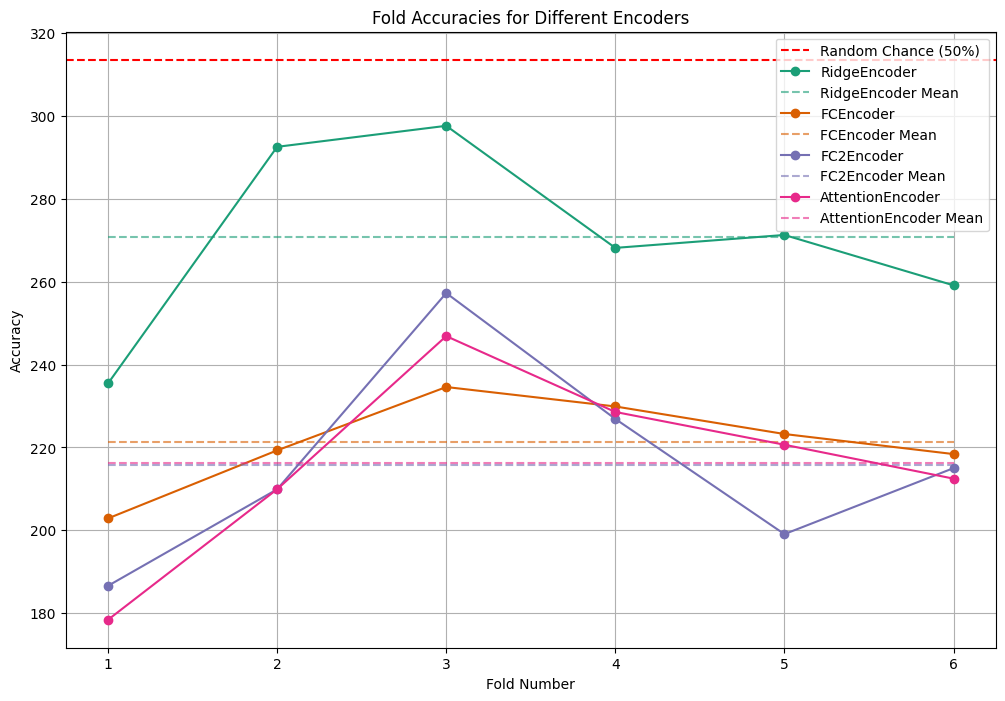

In [40]:
plot_encoders_results(encoder_list, entity_accuracies_list, fold_accuracies_list, dist='glove', total_points=exp23_fmri_glove_reduced.shape[0])

### Making the predictions (using experiments 2 and 3)

In [64]:
# Creating the encoder from the data used in the second experiment
encoder_glove = init_and_train_encoder(AttentionEncoder, exp23_fmri_glove_reduced, exp23_vecs)
# in order to avoid recomputing the encoder, we can save it
with open('data/encoder_glove.pkl', 'wb') as f:
    pickle.dump(encoder_glove, f)

In [ ]:
# if the encoder is already saved, we can load it
if os.path.exists('data/encoder_glove.pkl'):
    with open('data/encoder_glove.pkl', 'rb') as f:
        encoder_glove = pickle.load(f)

In [66]:
# for the sake of testing, let's reconstruct the first sentence from the second experiment
target_sentence = exp23_sent[70]
target_vector = exp23_vecs[70]
target_voxel_activation = exp23_fmri_reduced[70, :]
print(f"Target Sentence: {target_sentence}")

reconstructed_sentence, reconstructed_embedding, reconstruction_score = reconstruct_sentence_beam_search(
    encoder=encoder_glove,
    target_voxel_activation=target_voxel_activation,
    model=lm_model,
    tokenizer=lm_tokenizer,
    get_sequence_embedding=get_glove_sequence_embedding,
    max_length=15,
    k=20,
    beam_width=3
)
print(f"Reconstructed Sentence: {reconstructed_sentence}")
# calculating the cosine similarity between the target vector and the reconstructed embedding
if reconstructed_embedding is not None:
    cosine_similarity = np.dot(target_vector, reconstructed_embedding) / (np.linalg.norm(target_vector) * np.linalg.norm(reconstructed_embedding))
    print(f"Cosine Similarity between target and reconstructed embedding: {cosine_similarity:.4f}")
else:
    print("Reconstructed embedding is None, cannot calculate cosine similarity.")
print(f"Reconstruction Score: {reconstruction_score:.4f}")

Target Sentence: Chairs can also have back and arm rests, as well as a cushion.

--- Starting Sentence Reconstruction with Beam Search (width=3) ---


Reconstructing:   7%|▋         | 1/15 [00:01<00:16,  1.21s/word]

Step 1/15: Best Score=0.1720, Best Beam: '<|endoftext|> s'


Reconstructing:  13%|█▎        | 2/15 [00:02<00:16,  1.27s/word]

Step 2/15: Best Score=0.4526, Best Beam: '<|endoftext|> ekt'


Reconstructing:  20%|██        | 3/15 [00:03<00:15,  1.27s/word]

Step 3/15: Best Score=0.4985, Best Beam: '<|endoftext|> is no way'


Reconstructing:  27%|██▋       | 4/15 [00:05<00:13,  1.27s/word]

Step 4/15: Best Score=0.5516, Best Beam: '<|endoftext|> is no way on'


Reconstructing:  33%|███▎      | 5/15 [00:06<00:12,  1.28s/word]

Step 5/15: Best Score=0.5763, Best Beam: '<|endoftext|> is no place on any'


Reconstructing:  40%|████      | 6/15 [00:07<00:10,  1.19s/word]

Step 6/15: Best Score=0.6630, Best Beam: '<|endoftext|> is no place without their support'


Reconstructing:  47%|████▋     | 7/15 [00:08<00:08,  1.12s/word]

Step 7/15: Best Score=0.6849, Best Beam: '<|endoftext|> is no place without their support on'


Reconstructing:  53%|█████▎    | 8/15 [00:09<00:07,  1.05s/word]

Step 8/15: Best Score=0.6888, Best Beam: '<|endoftext|> is no place without their support on stage'


Reconstructing:  60%|██████    | 9/15 [00:10<00:06,  1.00s/word]

Step 9/15: Best Score=0.7131, Best Beam: '<|endoftext|> is no place without their support on any platform'


Reconstructing:  67%|██████▋   | 10/15 [00:11<00:04,  1.04word/s]

Step 10/15: Best Score=0.7175, Best Beam: '<|endoftext|> is no place without their support on any side except'


Reconstructing:  73%|███████▎  | 11/15 [00:11<00:03,  1.06word/s]

Step 11/15: Best Score=0.7310, Best Beam: '<|endoftext|> is no place without their support on any platform I support'


Reconstructing:  80%|████████  | 12/15 [00:12<00:02,  1.06word/s]

Step 12/15: Best Score=0.7354, Best Beam: '<|endoftext|> is no place without their support on any platform I have supported'


Reconstructing:  87%|████████▋ | 13/15 [00:13<00:01,  1.03word/s]

Step 13/15: Best Score=0.7406, Best Beam: '<|endoftext|> is no place without their support on any platform I have supported since'


Reconstructing:  93%|█████████▎| 14/15 [00:14<00:00,  1.04word/s]

Step 14/15: Best Score=0.7530, Best Beam: '<|endoftext|> is no place without their support on any platform I support including Apple devices'


Step 15/15: Best Score=0.7530, Best Beam: '<|endoftext|> is no place without their support on any platform I support including Apple devices I'
--- Reconstruction Complete ---
Reconstructed Sentence:  is no place without their support on any platform I support including Apple devices I
Cosine Similarity between target and reconstructed embedding: 0.8206
Reconstruction Score: 0.7530


In [80]:
# testing the reconstruction
glove_reconstruction_results = test_sentence_reconstruction(
    sent=exp23_sent, 
    vecs=exp23_vecs, 
    voxels=exp23_fmri_reduced, 
    encoder=encoder_glove, 
    model=lm_model, 
    tokenizer=lm_tokenizer, 
    get_sequence_embedding=get_glove_sequence_embedding, 
    num_sentences=50,
    print_progress=False,
    max_length=15,
    k=20,
    beam_width=3,
    custom_indices=exp23_test_reconstruction_indices
)
# saving the results
with open('data/glove_reconstruction_results.pkl', 'wb') as f:
    pickle.dump(glove_reconstruction_results, f)

Reconstructing Sentences:  34%|███▍      | 17/50 [04:03<07:52, 14.32s/sentence]/var/folders/hz/fhxj23ds6q7d1qsrgm6xhz180000gn/T/ipykernel_56457/3284097468.py:60: RuntimeWarning: invalid value encountered in scalar divide
  cosine_similarity = np.dot(target_vector, reconstructed_embedding) / (np.linalg.norm(target_vector) * np.linalg.norm(reconstructed_embedding))
Reconstructing Sentences: 100%|██████████| 50/50 [11:54<00:00, 14.30s/sentence]


In [7]:
# if the results are already saved, we can load them
if os.path.exists('data/glove_reconstruction_results.pkl'):
    with open('data/glove_reconstruction_results.pkl', 'rb') as f:
        glove_reconstruction_results = pickle.load(f)

In [7]:
print_sentence_reconstruction_results(glove_reconstruction_results, desc="glove")


--- Sentence Reconstruction Results ---
Sentence 1:
Original: Their appearance and abilities makes them popular pets.
Reconstructed:  bør lille barna sproket og skræmt ud
Cosine Similarity: 0.0057
Reconstruction Score: 0.6809

Sentence 2:
Original: Even beginner rock climbing takes courage and strength.
Reconstructed:  István Szabó has become more powerful as it takes hold
Cosine Similarity: 0.8222
Reconstruction Score: 0.7616

Sentence 3:
Original: She has to use solid elements of design, like strong composition and lighting.
Reconstructed:  with respect both at individual subject of a group therapy is important due especially also
Cosine Similarity: 0.8450
Reconstruction Score: 0.9114

Sentence 4:
Original: Flood can be caused by heavy rain or rapid snow melt, as well as earthquakes at sea.
Reconstructed:  fiz a cách cung k go luath ag cail
Cosine Similarity: 0.4743
Reconstruction Score: 0.7228

Sentence 5:
Original: When open, a window will also let air and sound through.
Reconstru

Average Cosine Similarity: 0.6472 with std: 0.2682
Average Reconstruction Score: 0.7342 with std: 0.1042


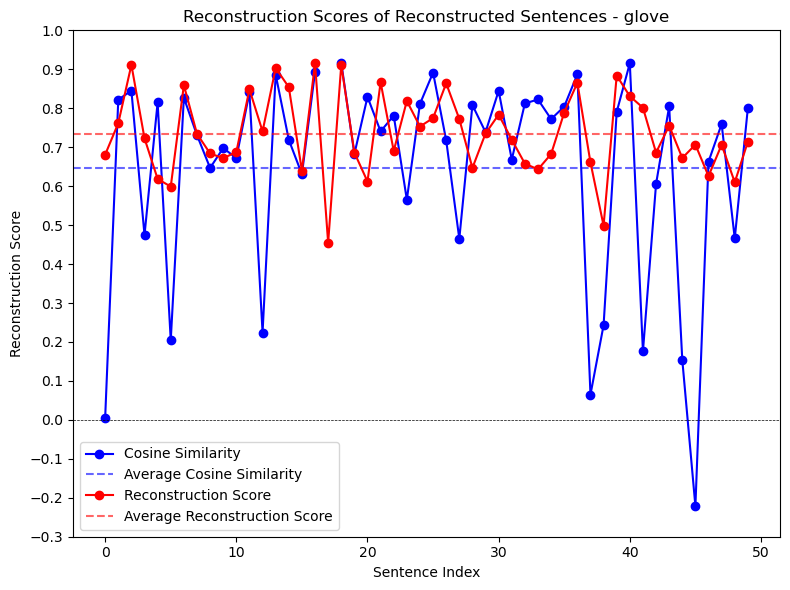

In [7]:
plot_sentence_reconstruction_results(glove_reconstruction_results, desc="glove")

In [5]:
# create a list of hand crafted evaluations of the reconstruction results using the following logic:
# Every reconstruction is assigned a score between 0 and 1 where
# 0 corresponds to a completely non-sensical reconstruction
# 1/4 corresponds to a text which could be a sentence but is unrelated to the desired output
# 2/4 corresponds to a text which could be a sentence and has some concepts from the desired output
# 3/4 corresponds to a text which could be a sentence and is closely related to the desired output
# 1 corresponds to a text which is almost a desired output
glove_evaluations = [0, 2/4, 1/4, 0, 1/4, 0, 3/4, 1/4, 1/4, 1/4,
                     1/4, 3/4, 0, 2/4, 1/4, 1/4, 1, 0, 3/4, 0,
                     1/4, 1/4, 2/4, 1/4, 1/4, 2/4, 1/2, 0, 2/4, 1/4,
                     1/4, 1/4, 1/4, 1/4, 0, 1/4, 1/4, 0, 0, 1/4, 
                     3/4, 0, 1/4, 1/4, 0, 0, 1/4, 1/4, 0, 1/4]

Score: 0.0, Count: 14 or 28.00%, Examples: [1, 4, 6, 13, 18, 20, 28, 35, 38, 39, 42, 45, 46, 49]
Score: 0.25, Count: 25 or 50.00%, Examples: [3, 5, 8, 9, 10, 11, 15, 16, 21, 22, 24, 25, 30, 31, 32, 33, 34, 36, 37, 40, 43, 44, 47, 48, 50]
Score: 0.5, Count: 6 or 12.00%, Examples: [2, 14, 23, 26, 27, 29]
Score: 0.75, Count: 4 or 8.00%, Examples: [7, 12, 19, 41]
Score: 1.0, Count: 1 or 2.00%, Examples: [17]


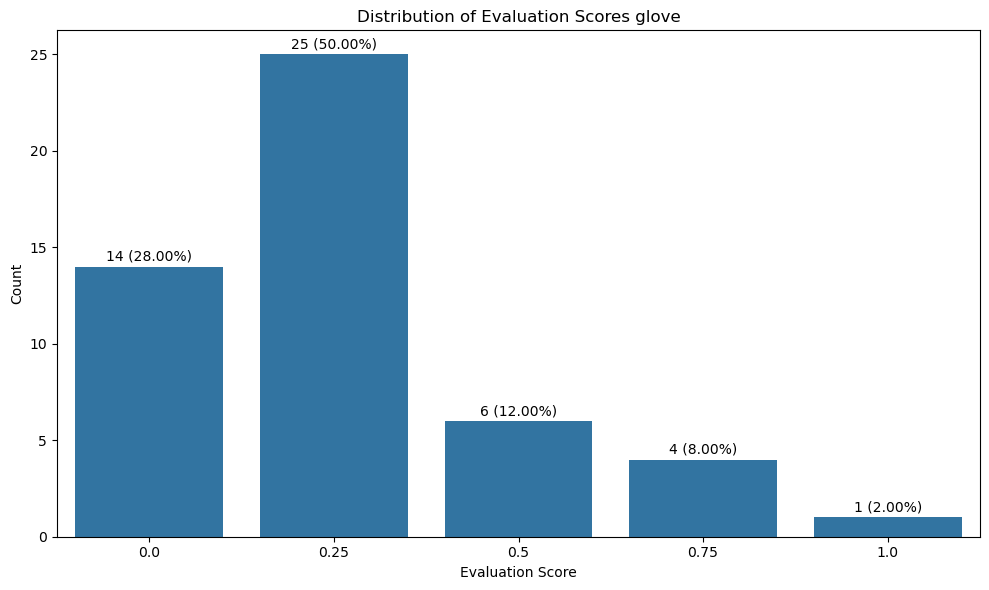

Correlation Coefficient for cosine similarities: 0.67


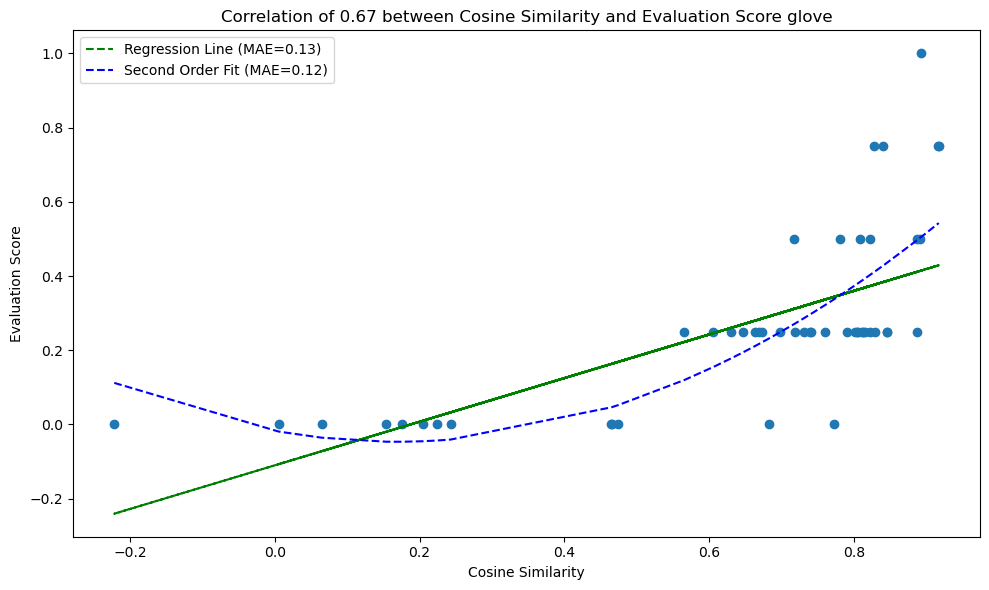

Correlation Coefficient for reconstruction scores: 0.57


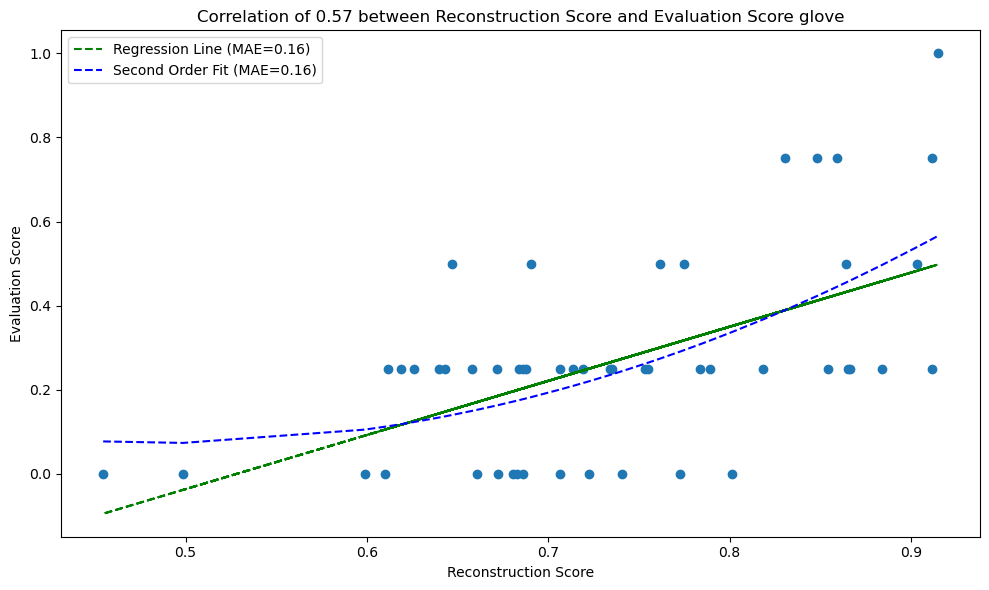

In [15]:
plot_reconstruction_evaluation_results(glove_reconstruction_results, glove_evaluations, desc="glove")

In [89]:
del glove_embs, encoder_glove

## Sentence embeddings to Voxel Prediction

## Using LLM

### Testing different Encoders with the LLM vectors (combined data from exp2 and exp3)

In [28]:
llm_encoder_list = [RidgeEncoder, FCEncoder, FC2Encoder, AttentionEncoder]

In [52]:
llm_entity_accuracies_list, llm_fold_accuracies_list = test_different_encoders(llm_encoder_list, exp23_fmri_reduced, exp23_vecs_llm, n_folds=6, dist='llm_exp23')

Results for RidgeEncoder already computed, skipping.
Results for FCEncoder already computed, skipping.
Results for FC2Encoder already computed, skipping.
Results for AttentionEncoder already computed, skipping.


/var/folders/hz/fhxj23ds6q7d1qsrgm6xhz180000gn/T/ipykernel_56457/590963294.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2')


Average rank of RidgeEncoder: 235.75 or 37.60% of total
Average rank of FCEncoder: 214.48 or 34.21% of total
Average rank of FC2Encoder: 318.60 or 50.81% of total
Average rank of AttentionEncoder: 189.52 or 30.23% of total


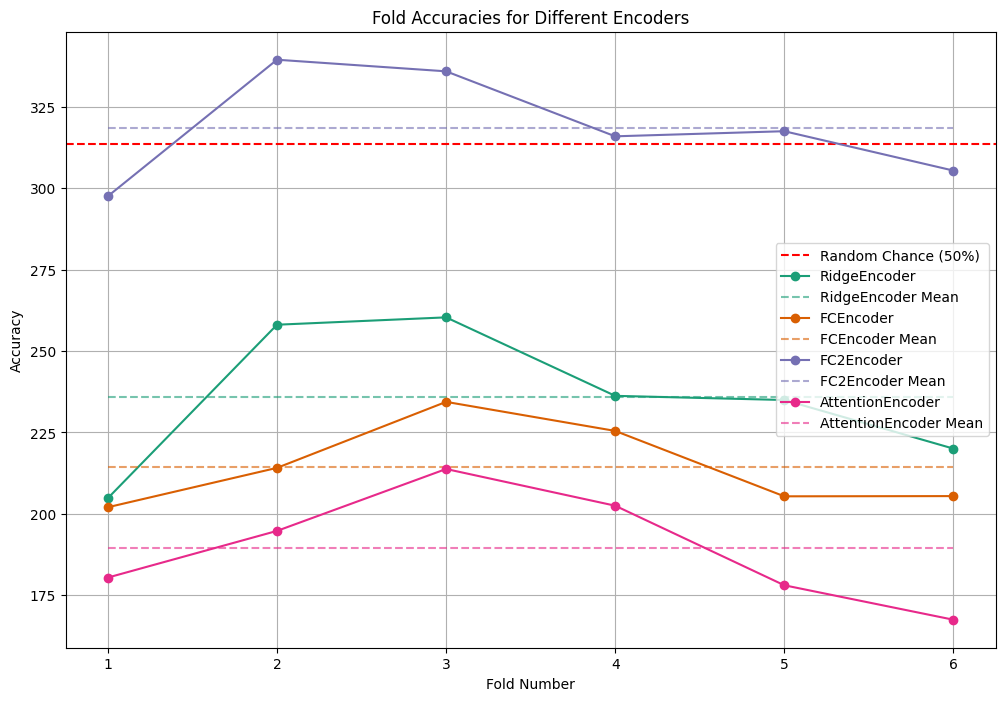

In [53]:
plot_encoders_results(llm_encoder_list, llm_entity_accuracies_list, llm_fold_accuracies_list, dist='llm_exp23', total_points=exp23_fmri_reduced.shape[0])

In [ ]:
# clean the saved results if needed
# remove all files from outputs/ which end with llm_exp23

# files = glob.glob('outputs/*llm_exp23*')
# for f in files:
#     os.remove(f)

### Testing different Encoders with the LLM vectors (combined data from exp2 and exp3) 
### using correlation loss

In [29]:
llm_encoder_list = [RidgeEncoder, FCEncoder, FC2Encoder, AttentionEncoder]
llm_encoder_kwargs = [None, {'metric': 'corr'}, {'metric': 'corr'}, {'metric': 'corr'}]

In [32]:
llm_entity_accuracies_list, llm_fold_accuracies_list = test_different_encoders(llm_encoder_list, exp23_fmri_reduced, exp23_vecs_llm, n_folds=6, dist='llm_exp23_corr', encoder_kwargs=llm_encoder_kwargs)

Testing AttentionEncoder on Folds: 100%|██████████| 6/6 [1:10:43<00:00, 707.26s/fold]


/var/folders/hz/fhxj23ds6q7d1qsrgm6xhz180000gn/T/ipykernel_36496/590963294.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Dark2')


Average rank of RidgeEncoder: 235.75 or 37.60% of total
Average rank of FCEncoder: 208.97 or 33.33% of total
Average rank of FC2Encoder: 201.68 or 32.17% of total
Average rank of AttentionEncoder: 197.44 or 31.49% of total


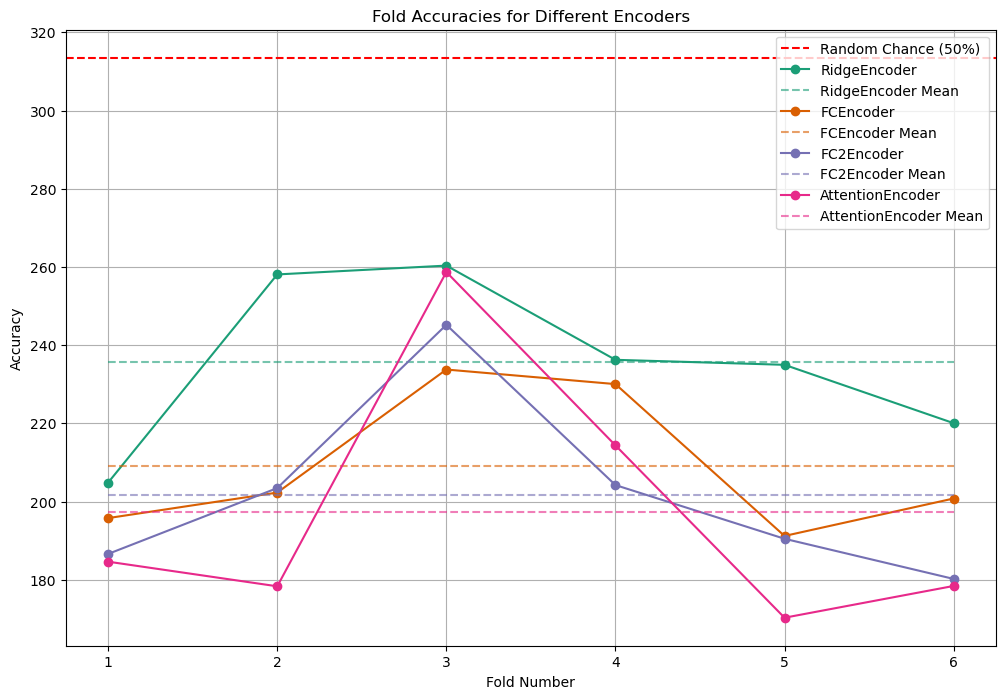

In [33]:
plot_encoders_results(llm_encoder_list, llm_entity_accuracies_list, llm_fold_accuracies_list, dist='llm_exp23_corr', total_points=exp23_fmri_reduced.shape[0])

In [ ]:
# clean the saved results if needed
# remove all files from outputs/ which end with llm_exp23_corr

# files = glob.glob('outputs/*llm_exp23_corr*')
# for f in files:
#     os.remove(f)

### Making the predictions (using experiments 2 and 3)

In [ ]:
encoder_llm = init_and_train_encoder(AttentionEncoder, exp23_fmri_reduced, exp23_vecs_llm)
# in order to avoid recomputing the encoder, we can save it
with open('data/encoder_llm.pkl', 'wb') as f:
    pickle.dump(encoder_llm, f)

In [90]:
# if the encoder is already saved, we can load it
if os.path.exists('data/encoder_llm.pkl'):
    with open('data/encoder_llm.pkl', 'rb') as f:
        encoder_llm = pickle.load(f)

In [91]:
# for the sake of testing, let's reconstruct the first sentence from the second experiment
target_sentence = exp23_sent[70]
target_vector = exp23_vecs_llm[70]
target_voxel_activation = exp23_fmri_reduced[70, :]
print(f"Target Sentence: {target_sentence}")

reconstructed_sentence, reconstructed_embedding, reconstruction_score = reconstruct_sentence_beam_search(
    encoder=encoder_llm,
    target_voxel_activation=target_voxel_activation,
    model=lm_model,
    tokenizer=lm_tokenizer,
    get_sequence_embedding=get_llm_sequence_embedding,
    max_length=15,
    k=20,
    beam_width=3
)
print(f"Reconstructed Sentence: {reconstructed_sentence}")
# calculating the cosine similarity between the target vector and the reconstructed embedding
if reconstructed_embedding is not None:
    cosine_similarity = np.dot(target_vector, reconstructed_embedding) / (np.linalg.norm(target_vector) * np.linalg.norm(reconstructed_embedding))
    print(f"Cosine Similarity between target and reconstructed embedding: {cosine_similarity:.4f}")
else:
    print("Reconstructed embedding is None, cannot calculate cosine similarity.")
print(f"Reconstruction Score: {reconstruction_score:.4f}")

Target Sentence: Chairs can also have back and arm rests, as well as a cushion.

--- Starting Sentence Reconstruction with Beam Search (width=3) ---


Reconstructing:   7%|▋         | 1/15 [00:06<01:35,  6.82s/word]

Step 1/15: Best Score=0.3803, Best Beam: '<|endoftext|> s'


Reconstructing:  13%|█▎        | 2/15 [00:27<03:15, 15.03s/word]

Step 2/15: Best Score=0.4390, Best Beam: '<|endoftext|> in his'


Reconstructing:  20%|██        | 3/15 [00:52<03:53, 19.49s/word]

Step 3/15: Best Score=0.5073, Best Beam: '<|endoftext|> in his or'


Reconstructing:  27%|██▋       | 4/15 [01:13<03:42, 20.21s/word]

Step 4/15: Best Score=0.5218, Best Beam: '<|endoftext|> in his or my'


Reconstructing:  33%|███▎      | 5/15 [01:29<03:04, 18.44s/word]

Step 5/15: Best Score=0.5302, Best Beam: '<|endoftext|> in his or our best'


Reconstructing:  40%|████      | 6/15 [01:43<02:34, 17.15s/word]

Step 6/15: Best Score=0.5405, Best Beam: '<|endoftext|> in his or our best to'


Reconstructing:  47%|████▋     | 7/15 [01:56<02:05, 15.71s/word]

Step 7/15: Best Score=0.5362, Best Beam: '<|endoftext|> in his or my book to provide'


Reconstructing:  53%|█████▎    | 8/15 [02:09<01:43, 14.82s/word]

Step 8/15: Best Score=0.5480, Best Beam: '<|endoftext|> in his or my book to include in'


Reconstructing:  60%|██████    | 9/15 [02:22<01:25, 14.19s/word]

Step 9/15: Best Score=0.5600, Best Beam: '<|endoftext|> in his or my book to include in the'


Reconstructing:  67%|██████▋   | 10/15 [02:34<01:08, 13.75s/word]

Step 10/15: Best Score=0.5698, Best Beam: '<|endoftext|> in his or my book to include in the end'


Reconstructing:  73%|███████▎  | 11/15 [02:47<00:53, 13.49s/word]

Step 11/15: Best Score=0.5778, Best Beam: '<|endoftext|> in his or my book to include in the story or'


Reconstructing:  80%|████████  | 12/15 [03:00<00:39, 13.33s/word]

Step 12/15: Best Score=0.5815, Best Beam: '<|endoftext|> in his or my book to include in their story or story'


Reconstructing:  87%|████████▋ | 13/15 [03:13<00:26, 13.19s/word]

Step 13/15: Best Score=0.5867, Best Beam: '<|endoftext|> in his or my book to include in their story or story or'


Reconstructing:  93%|█████████▎| 14/15 [03:26<00:13, 13.06s/word]

Step 14/15: Best Score=0.5910, Best Beam: '<|endoftext|> in his or my book to include in their story or story or short'


Step 15/15: Best Score=0.5929, Best Beam: '<|endoftext|> in his or my book to include in their story or story or short in'
--- Reconstruction Complete ---


Reconstructed Sentence:  in his or my book to include in their story or story or short in
Cosine Similarity between target and reconstructed embedding: 0.8058
Reconstruction Score: 0.5929


In [94]:
# testing the sentence reconstruction
llm_reconstruction_results = test_sentence_reconstruction(
    sent=exp23_sent,
    vecs=exp23_vecs_llm,
    voxels=exp23_fmri_reduced,
    encoder=encoder_llm,
    model=lm_model,
    tokenizer=lm_tokenizer,
    get_sequence_embedding=get_llm_sequence_embedding,
    num_sentences=50,
    print_progress=False,
    max_length=15,
    k=20,
    beam_width=3,
    custom_indices=exp23_test_reconstruction_indices
)
# saving the results
with open('data/llm_reconstruction_results.pkl', 'wb') as f:
    pickle.dump(llm_reconstruction_results, f)

Reconstructing Sentences: 100%|██████████| 50/50 [2:54:47<00:00, 209.75s/sentence]  


In [9]:
# if we want to load the results later
if os.path.exists('data/llm_reconstruction_results.pkl'):
    with open('data/llm_reconstruction_results.pkl', 'rb') as f:
        llm_reconstruction_results = pickle.load(f)

In [10]:
print_sentence_reconstruction_results(llm_reconstruction_results, desc="llm")


--- Sentence Reconstruction Results ---
Sentence 1:
Original: Their appearance and abilities makes them popular pets.
Reconstructed:  sitten on mukaan yhä enemämäkin meneilla m
Cosine Similarity: 0.4290
Reconstruction Score: 0.6780

Sentence 2:
Original: Even beginner rock climbing takes courage and strength.
Reconstructed:  britnoyevropskayya organizaciālie strukayna
Cosine Similarity: 0.4374
Reconstruction Score: 0.7029

Sentence 3:
Original: She has to use solid elements of design, like strong composition and lighting.
Reconstructed:  fotoforhidrofuran in rat brain using radiol
Cosine Similarity: 0.5162
Reconstruction Score: 0.8443

Sentence 4:
Original: Flood can be caused by heavy rain or rapid snow melt, as well as earthquakes at sea.
Reconstructed:  Visa Application is designed speciallyfor Chinese passport application with more efficient time on
Cosine Similarity: 0.6796
Reconstruction Score: 0.7451

Sentence 5:
Original: When open, a window will also let air and sound through

Average Cosine Similarity: 0.6146 with std: 0.2411
Average Reconstruction Score: 0.7117 with std: 0.1246


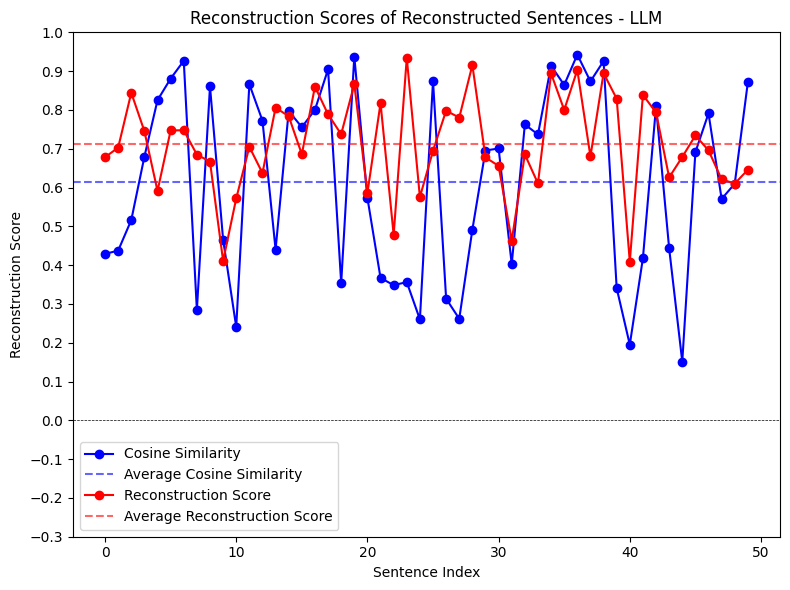

In [11]:
plot_sentence_reconstruction_results(llm_reconstruction_results, desc="LLM")

In [10]:
# create a list of hand crafted evaluations of the reconstruction results using the following logic:
# Every reconstruction is assigned a score between 0 and 1 where
# 0 corresponds to a completely non-sensical reconstruction
# 1/4 corresponds to a text which could be a sentence but is unrelated to the desired output
# 2/4 corresponds to a text which could be a sentence and has some concepts from the desired output
# 3/4 corresponds to a text which could be a sentence and is closely related to the desired output
# 1 corresponds to a text which is almost a desired output
llm_evaluations = [0, 0, 0, 1/4, 1/4, 2/4, 1/4, 0, 1/4, 0,
                   0, 2/4, 1/4, 0, 1/4, 1/4, 3/4, 2/4, 0, 3/4,
                   0, 0, 0, 0, 0, 1/4, 0, 0, 0, 1/4,
                   1/4, 0, 1/4, 1/4, 1/4, 1/4, 3/4, 2/4, 3/4, 0,
                   0, 0, 1/4, 0, 0, 1/4, 1/4, 0, 1/4, 1/4]

Score: 0.0, Count: 23 or 46.00%, Examples: [1, 2, 3, 8, 10, 11, 14, 19, 21, 22, 23, 24, 25, 27, 28, 29, 32, 40, 41, 42, 44, 45, 48]
Score: 0.25, Count: 19 or 38.00%, Examples: [4, 5, 7, 9, 13, 15, 16, 26, 30, 31, 33, 34, 35, 36, 43, 46, 47, 49, 50]
Score: 0.5, Count: 4 or 8.00%, Examples: [6, 12, 18, 38]
Score: 0.75, Count: 4 or 8.00%, Examples: [17, 20, 37, 39]


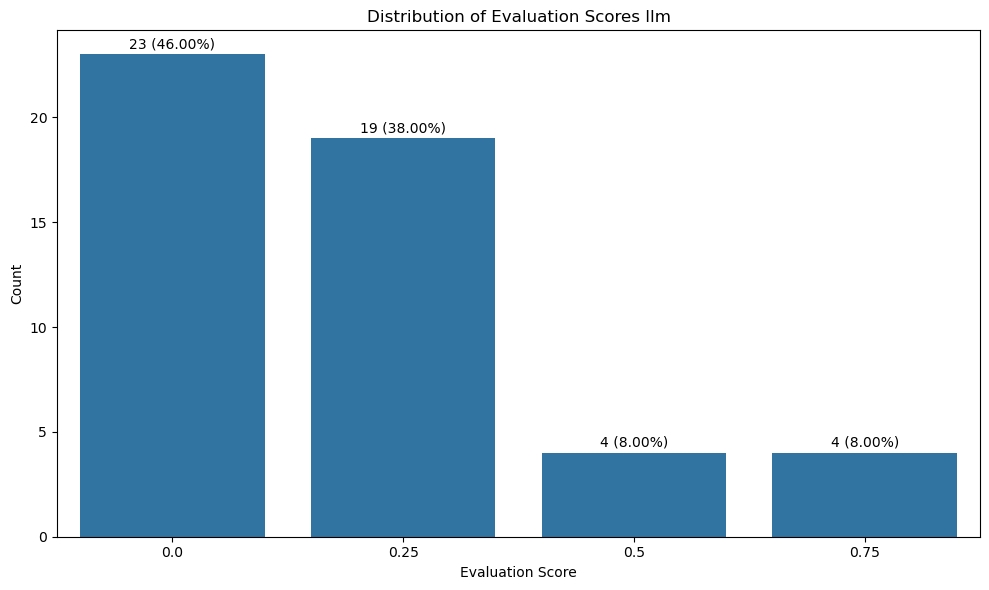

Correlation Coefficient for cosine similarities: 0.81


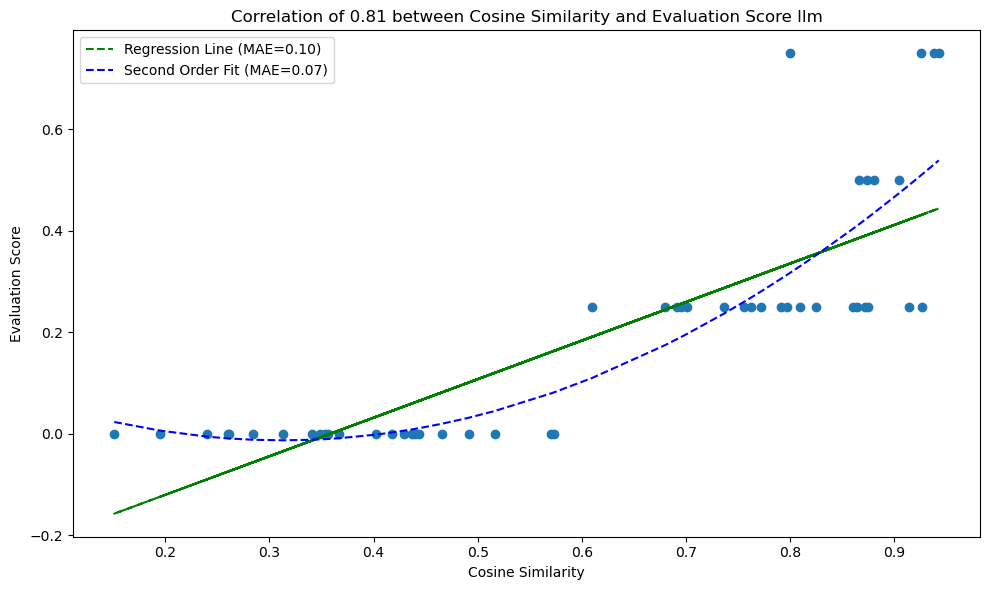

Correlation Coefficient for reconstruction scores: 0.36


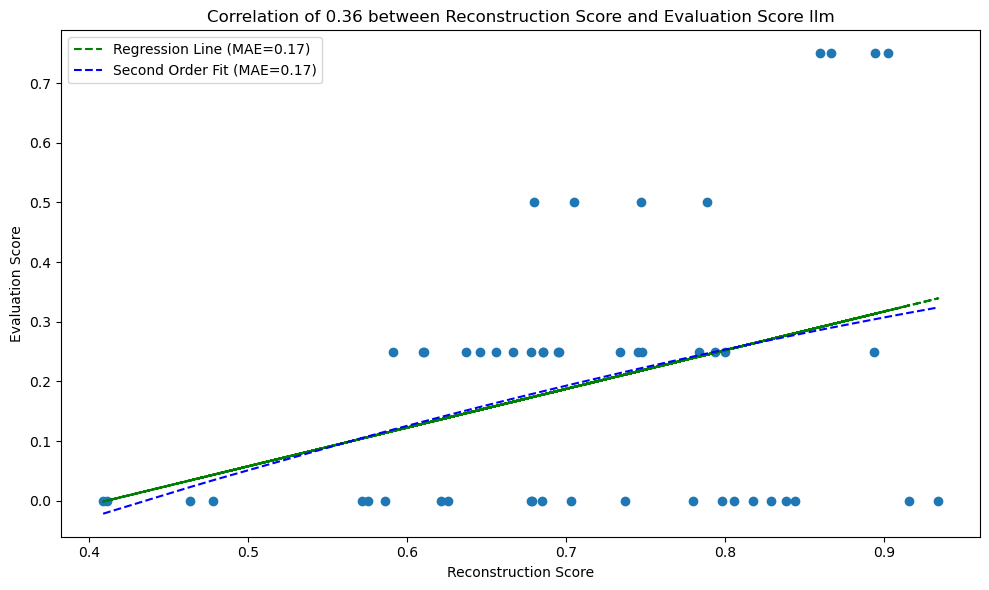

In [16]:
plot_reconstruction_evaluation_results(llm_reconstruction_results, llm_evaluations, desc="llm")

In [63]:
del encoder_llm

In [12]:
# combining all reconstruction results
all_reconstruction_results = {}
for key in llm_reconstruction_results:
    if type(llm_reconstruction_results[key]) is not list:
        llm_reconstruction_results[key] = llm_reconstruction_results[key].tolist()
    if type(glove_reconstruction_results[key]) is not list:
        glove_reconstruction_results[key] = glove_reconstruction_results[key].tolist()
    all_reconstruction_results[key] = llm_reconstruction_results[key] + glove_reconstruction_results[key]
all_evaluation_results = llm_evaluations + glove_evaluations

Score: 0.0, Count: 37 or 37.00%, Examples: [1, 2, 3, 8, 10, 11, 14, 19, 21, 22, 23, 24, 25, 27, 28, 29, 32, 40, 41, 42, 44, 45, 48, 51, 54, 56, 63, 68, 70, 78, 85, 88, 89, 92, 95, 96, 99]
Score: 0.25, Count: 44 or 44.00%, Examples: [4, 5, 7, 9, 13, 15, 16, 26, 30, 31, 33, 34, 35, 36, 43, 46, 47, 49, 50, 53, 55, 58, 59, 60, 61, 65, 66, 71, 72, 74, 75, 80, 81, 82, 83, 84, 86, 87, 90, 93, 94, 97, 98, 100]
Score: 0.5, Count: 10 or 10.00%, Examples: [6, 12, 18, 38, 52, 64, 73, 76, 77, 79]
Score: 0.75, Count: 8 or 8.00%, Examples: [17, 20, 37, 39, 57, 62, 69, 91]
Score: 1.0, Count: 1 or 1.00%, Examples: [67]


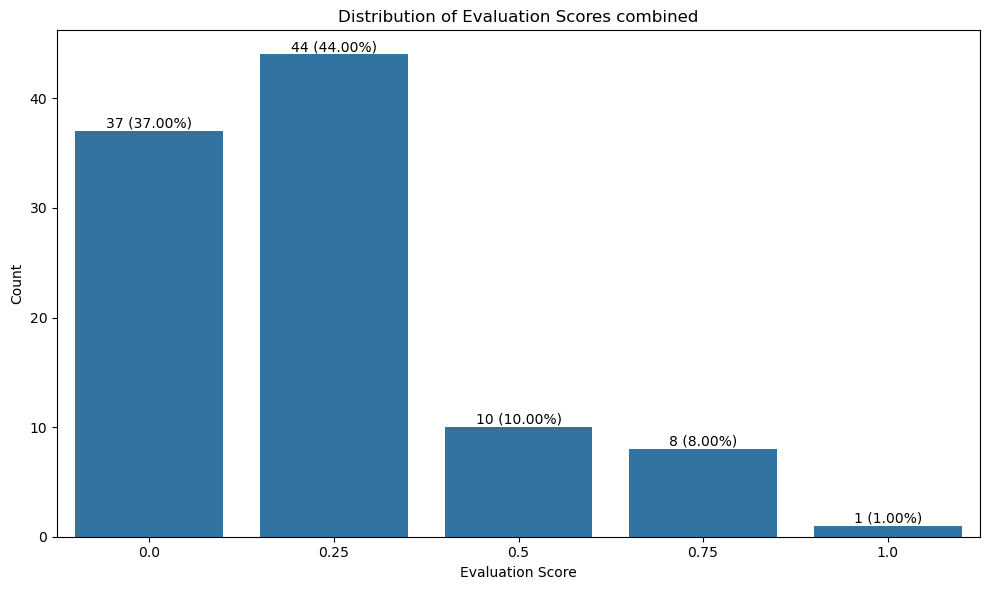

Correlation Coefficient for cosine similarities: 0.73


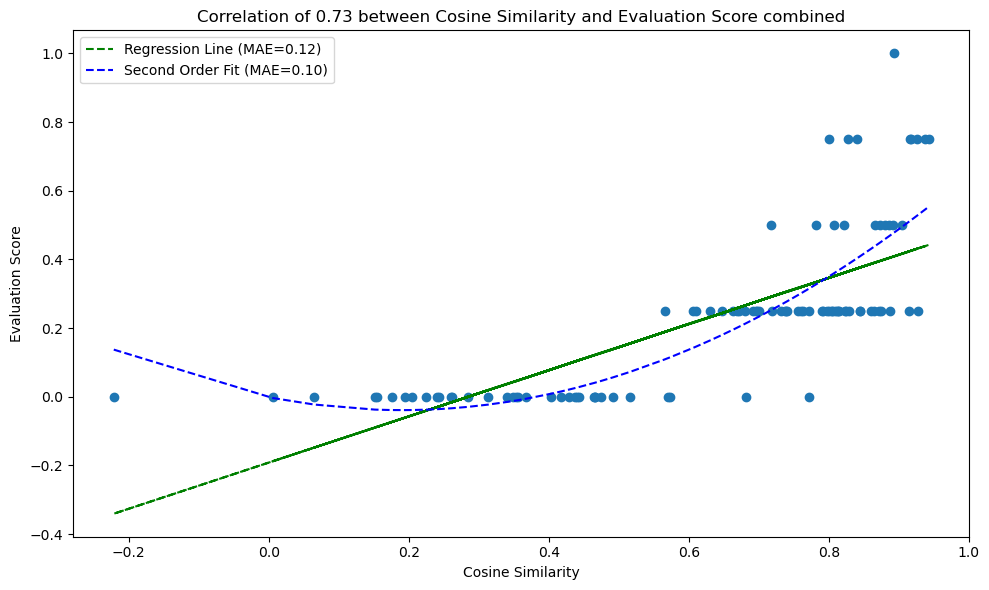

Correlation Coefficient for reconstruction scores: 0.46


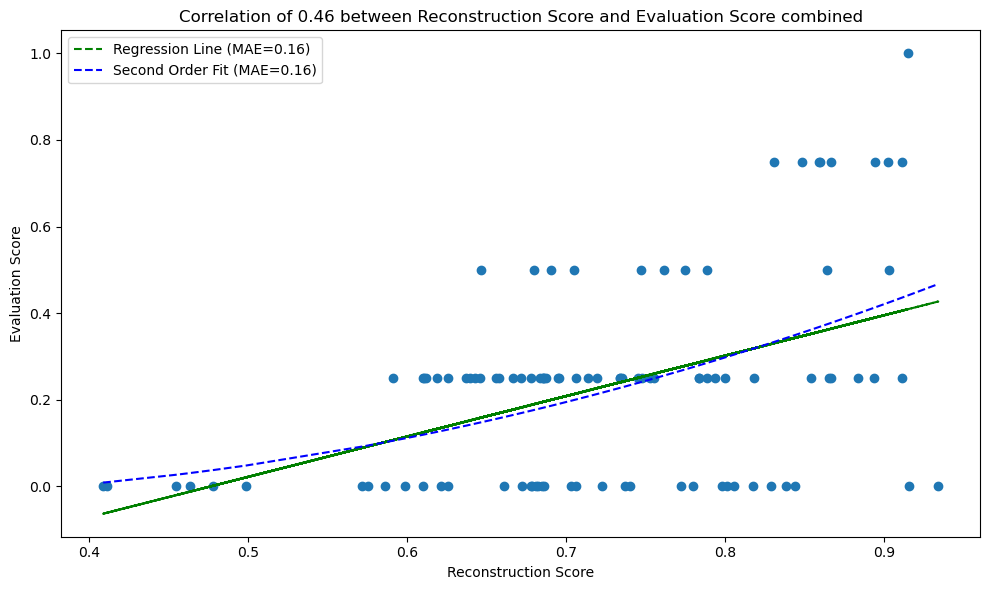

In [17]:
plot_reconstruction_evaluation_results(all_reconstruction_results, all_evaluation_results, desc="combined")